## Generate Synthetic Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)
n = 5000  # large enough for DL

# Features
x1 = np.random.uniform(0, 10, n)
x2 = np.random.normal(0, 1, n)
x3 = np.random.uniform(-5, 5, n)
x4 = np.random.beta(2, 5, n) * 10
x5 = np.random.binomial(1, 0.3, n)

# Target: Non-linear function with noise
y = 2.5 * np.sin(x1) + 0.8 * np.log1p(np.abs(x2)) - 0.5 * x3**2 + 1.2 * x4 + 3 * x5 + np.random.normal(0, 2, n)

# Create DataFrame
df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'x5': x5, 'target': y})


## Prepare Dataset And Dataloaders

In [2]:
X = df[['x1','x2','x3','x4','x5']].values
y = df[['target']].values


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, random_state=42, test_size=0.2)

In [4]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
Y_scaler = StandardScaler()


X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)


y_train_scaled = Y_scaler.fit_transform(y_train)
y_val_scaled = Y_scaler.transform(y_val)
y_test_scaled = Y_scaler.transform(y_test)

In [5]:
X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape

((3200, 5), (800, 5), (1000, 5))

In [6]:
from torch.utils.data import Dataset, DataLoader
import torch

class RegressionDataset(Dataset):
    def __init__(self, X,y):
        self.features = torch.tensor(X, dtype=torch.float32)
        self.targets = torch.tensor(y, dtype=torch.float32)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]

        return x,y

    def __len__(self):
        return len(self.features)

In [7]:
train_dataset = RegressionDataset(X_train_scaled, y_train_scaled)
val_dataset = RegressionDataset(X_val_scaled, y_val_scaled)
test_dataset = RegressionDataset(X_test_scaled, y_test_scaled)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

## PyTorch Model

In [8]:
class Regression(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.all_layers = torch.nn.Sequential(
            torch.nn.Linear(in_features=num_features, out_features=20),
            torch.nn.ReLU(),
            torch.nn.Linear(20,10),
            torch.nn.ReLU(),
            torch.nn.Linear(10,1)
        )

    def forward(self, x):
        prediction  = self.all_layers(x)
        return prediction

## Lightning Module

In [15]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger

class LightningRegression(L.LightningModule):

    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        features, targets = batch

        predictions =  self(features)

        # Calculate Loss
        loss_func = torch.nn.MSELoss()
        loss = loss_func(predictions, targets)

        self.log('train_loss', loss)

        return loss
    
    def validation_step(self, batch, batch_idx):
        features, targets = batch

        predictions =  self(features)

        # Calculate Loss
        loss_func = torch.nn.MSELoss()
        loss = loss_func(predictions, targets)

        self.log('val_loss', loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

## Training Loop

In [16]:
num_features = X_train_scaled.shape[1]
learning_rate = 0.01
max_epochs = 100


In [17]:
pytorch_model = Regression(num_features)
lightning_model = LightningRegression(model=pytorch_model, learning_rate=learning_rate)

In [18]:
from lightning.pytorch.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint(save_top_k=1,mode='min',monitor='val_loss',save_last=True)
]

In [19]:
trainer = L.Trainer(
        max_epochs=max_epochs,
        accelerator="auto",  # set to "auto" or "gpu" to use GPUs if available
        devices="auto",  # Uses all available GPUs if applicable
        logger = CSVLogger(save_dir="logs/", name='Regression'),
        gradient_clip_val=1,
        deterministic=True,
        callbacks=callbacks

    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(
    model=lightning_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)


  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Regression | 341    | train
---------------------------------------------
341       Trainable params
0         Non-trainable params
341       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


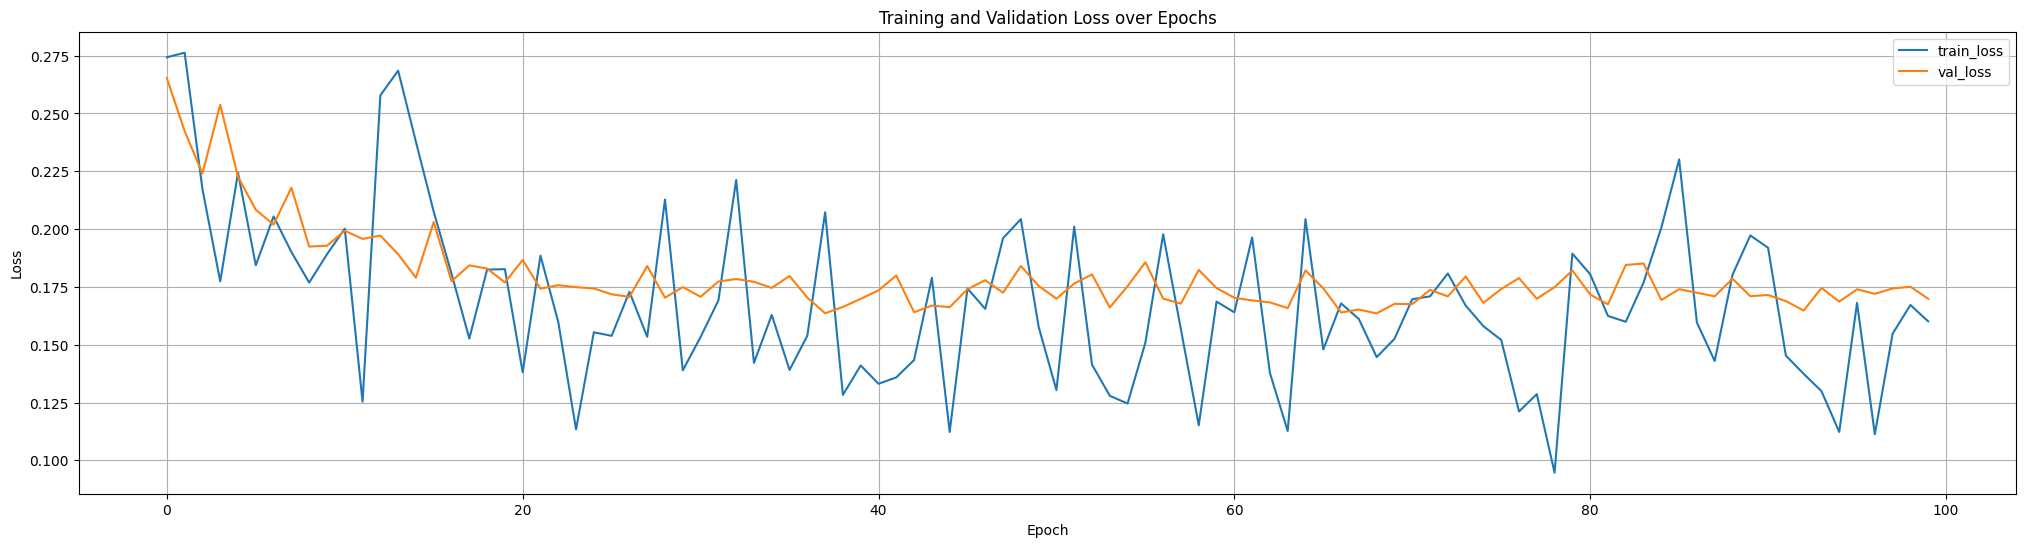

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load metrics
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

# Aggregate metrics by epoch
aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)

# Plot full history
plt.figure(figsize=(25, 6))  # Make the plot larger
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss", ax=plt.gca()
)
plt.title("Training and Validation Loss over Epochs")
plt.show()




In [23]:
best_model_path = trainer.checkpoint_callback.best_model_path
lightning_AE = LightningRegression.load_from_checkpoint(best_model_path,learning_rate=learning_rate,model=pytorch_model)
print('Best Model: ',best_model_path)

Best Model:  logs/Regression/version_2/checkpoints/epoch=68-step=6900.ckpt


## Evaluation

In [25]:
lightning_AE.eval()

with torch.no_grad():
    prediction = lightning_AE(torch.tensor(X_test_scaled, dtype=torch.float32))

In [29]:
y_test_scaled = torch.tensor(y_test_scaled)

In [30]:
torch.nn.MSELoss()(y_test_scaled,prediction)

tensor(0.1745, dtype=torch.float64)